# DSCI 100: Project Proposal 

In [1]:
# libraries 
library(tidyverse)
library(repr)
library(tidymodels) 
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ──────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ─────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()


### 1. Introduction

Auditing is the examination of businesses financial records and the inspection that they align with standard accounting laws and principles (Hooda, 2018). Certain factors of a business or firm, such as historical discrepancy between a financial report and an audit inspection can help auditors identify those that are higher risk for fraudulent activity. This dataset contains information about 777 firms, each of which are either classified as “Fraud” firms, or “Non-fraud” firms. 

The dataset aims to aid in the auditing process, by providing insight into whether a particular firm is “high risk” (in which case auditors would want to visit the firm) or “low risk” (in which case auditors may skip visiting that firm). Some of the risk factors examined in the dataset include discrepancies in reports, historical discrepancy scores, and amounts of money involved in misstatements. With this dataset, we will implement a K-nearest-neighbors classification model to identify "Fraud" firms from unseen datasets.

### 2. Preliminary EDA

#### Feature Descriptions

| -**Inherent risk factors**- |                                                                                               | -**Control risk factors**- |                                                                                     |
|-----------------------|-----------------------------------------------------------------------------------------------------|----------------------|-------------------------------------------------------------------------------------------|
| **Feature**           | Information                                                                                         | **Feature**          | Information                                                                               |
| Para A value          | Discrepancy found in the planned-expenditure of inspection and summary report A in Rs (in crore).   | Sector score         | Historical risk score value of the target-unit in the Table 1 using analytical procedure. |
| Para B value          | Discrepancy found in the unplanned-expenditure of inspection and summary report B in Rs (in crore). | Loss                 | Amount of loss suffered by the firm last year.                                            |
| Total                 | Total amount of discrepancy found in other reports Rs (in crore).                                   | History              | Average historical loss suffered by firm in the last 10¬†years.                           |
| Number                | Historical discrepancy score.                                                                       | District score       | Historical risk score of a district in the last 10¬†years.                                |
| Money value           | Amount of money involved in misstatements in the past audits.                                       |                      |                                                                                           |
| **Other features**    |                                                                                                     |                      |                                                                                           |
| **Feature**           | Information                                                                                         | **Feature**          | Information                                                                               |
| Sector ID             | Unique ID of the target sector.                                                                     | Location ID          | Unique ID of the city/province.                                                           |
| ARS                   | Total risk score using analytical procedure.                                                        | Audit ID             | Unique Id assigned to an audit case.                                                      |
| Risk class            | Risk Class assigned to an audit-case. (Target Feature)                                              |                      |                                                                                           |

In [2]:
audit <- read_csv("audit_data/audit_risk.csv") 
audit <- audit |> mutate(Risk = as.factor(Risk), LOCATION_ID = as.factor(LOCATION_ID))
head(audit)

New names:
• `Score_B` -> `Score_B...7`
• `Score_B` -> `Score_B...11`
Rows: 776 Columns: 27
── Column specification ──────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (26): Sector_score, PARA_A, Score_A, Risk_A, PARA_B, Score_B...7, Risk_B...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B...7,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
3.89,6,0.00,0.2,0.000,10.80,0.6,6.480,10.80,6,⋯,0.4,0,0.2,0,4.4,17.530,0.4,0.5,3.5060,1
3.89,6,0.00,0.2,0.000,0.08,0.2,0.016,0.08,5,⋯,0.4,0,0.2,0,2.0,1.416,0.4,0.5,0.2832,0
3.89,6,0.00,0.2,0.000,0.83,0.2,0.166,0.83,5,⋯,0.4,0,0.2,0,2.0,2.156,0.4,0.5,0.4312,0


In [3]:
# Tidying the Data

audit_tidy <- audit |>
  pivot_longer(cols = starts_with("PARA_"), names_to = "discrepancy", values_to = "discrepancy_value") |>
  pivot_longer(cols = starts_with("Score_"), names_to = "score_variable", values_to = "score_value") |>
  pivot_longer(cols = starts_with("Risk_"), names_to = "risk_variable", values_to = "risk_value")

head(audit_tidy)

Sector_score,LOCATION_ID,TOTAL,numbers,Money_Value,District_Loss,PROB,History,Prob,Score,⋯,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk,discrepancy,discrepancy_value,score_variable,score_value,risk_variable,risk_value
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_A,2.508
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_B,0.500
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_C,1.000
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_D,0.676
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,RiSk_E,0.400
3.89,23,6.68,5,3.38,2,0.2,0,0.2,2.4,⋯,0.4,0.5,1.7148,1,PARA_A,4.18,Score_A,0.6,Risk_F,0.000


In [4]:
summary(audit_tidy)

  Sector_score    LOCATION_ID        TOTAL              numbers     
 Min.   : 1.85   8      : 3648   Min.   :   0.0000   Min.   :5.000  
 1st Qu.: 2.37   19     : 3264   1st Qu.:   0.5375   1st Qu.:5.000  
 Median : 3.89   9      : 2544   Median :   1.3700   Median :5.000  
 Mean   :20.18   16     : 2496   Mean   :  13.2185   Mean   :5.068  
 3rd Qu.:55.57   12     : 2256   3rd Qu.:   7.7075   3rd Qu.:5.000  
 Max.   :59.85   5      : 2112   Max.   :1268.9100   Max.   :9.000  
                 (Other):20928                                      
  Money_Value     District_Loss        PROB           History      
 Min.   :  0.00   Min.   :2.000   Min.   :0.2000   Min.   :0.0000  
 1st Qu.:  0.00   1st Qu.:2.000   1st Qu.:0.2000   1st Qu.:0.0000  
 Median :  0.09   Median :2.000   Median :0.2000   Median :0.0000  
 Mean   : 14.14   Mean   :2.505   Mean   :0.2062   Mean   :0.1044  
 3rd Qu.:  5.61   3rd Qu.:2.000   3rd Qu.:0.2000   3rd Qu.:0.0000  
 Max.   :935.03   Max.   :6.000   Max.  

In [5]:
# Train Test Split
risk_split <- initial_split(audit_tidy, prop = 0.75, strata = Risk)
risk_train <- training(risk_split)
risk_test <- testing(risk_split) 

head(risk_train)

Sector_score,LOCATION_ID,TOTAL,numbers,Money_Value,District_Loss,PROB,History,Prob,Score,⋯,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk,discrepancy,discrepancy_value,score_variable,score_value,risk_variable,risk_value
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_A,0.2,Risk_A,0.000
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_A,0.2,Risk_B,0.966
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_A,0.2,Risk_C,1.000
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_A,0.2,RiSk_E,0.400
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_A,0.2,Risk_F,0.000
3.89,6,4.83,5,0.94,2,0.2,0,0.2,2,⋯,0.4,0.5,0.5108,0,PARA_A,0,Score_B...7,0.2,Risk_A,0.000


Warning message:
“Transformation introduced infinite values in continuous
x-axis”
Warning message:
“Transformation introduced infinite values in continuous
x-axis”
Warning message:
“Transformation introduced infinite values in continuous
y-axis”
Warning message:
“Removed 48 rows containing missing values (`geom_point()`).”


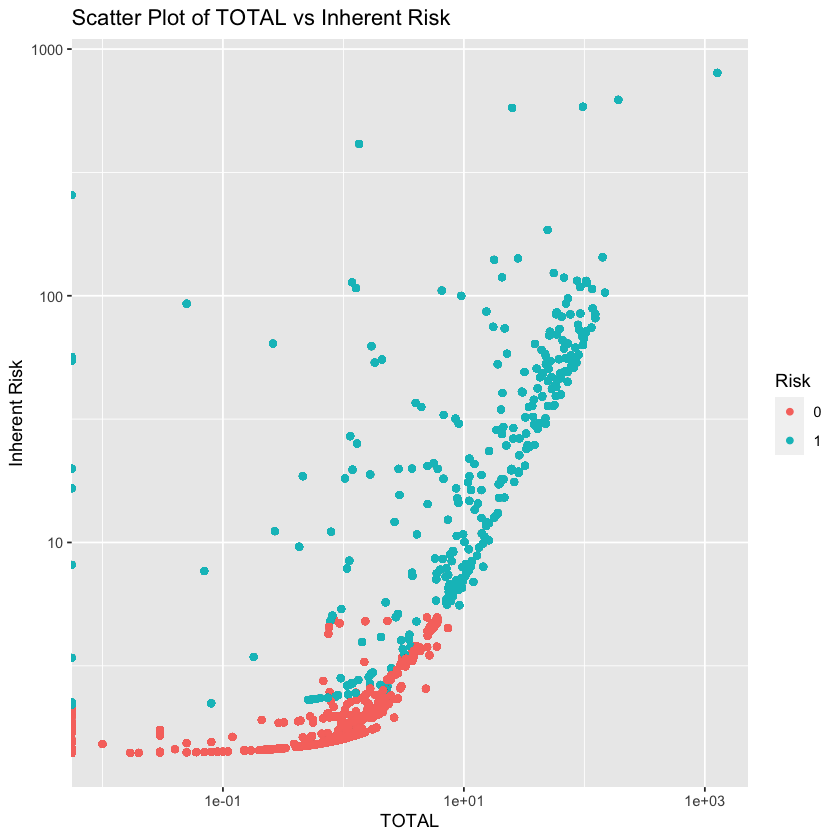

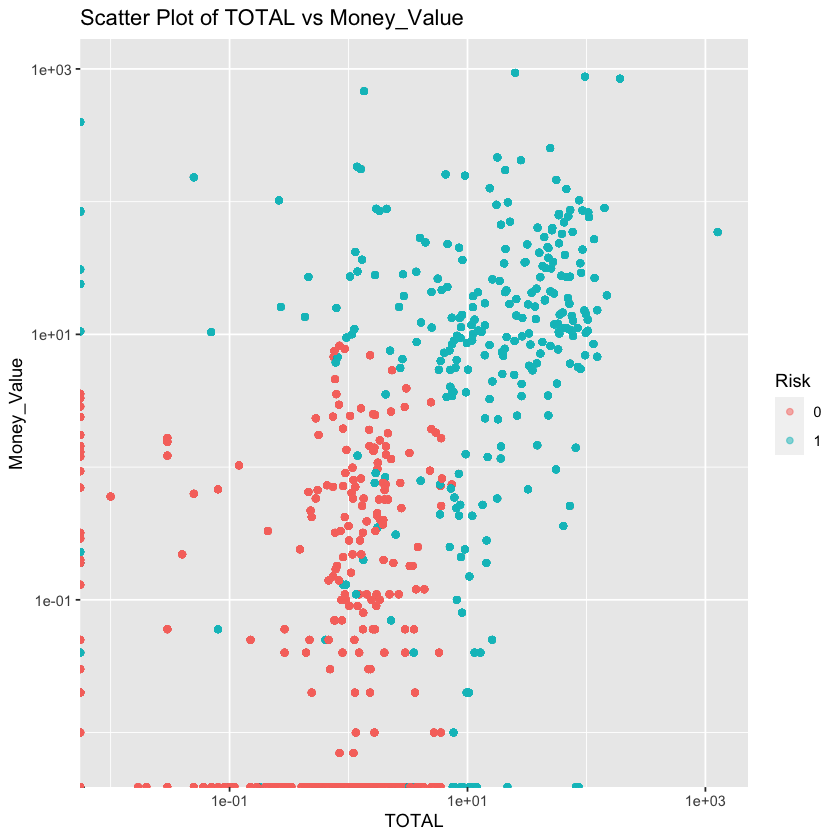

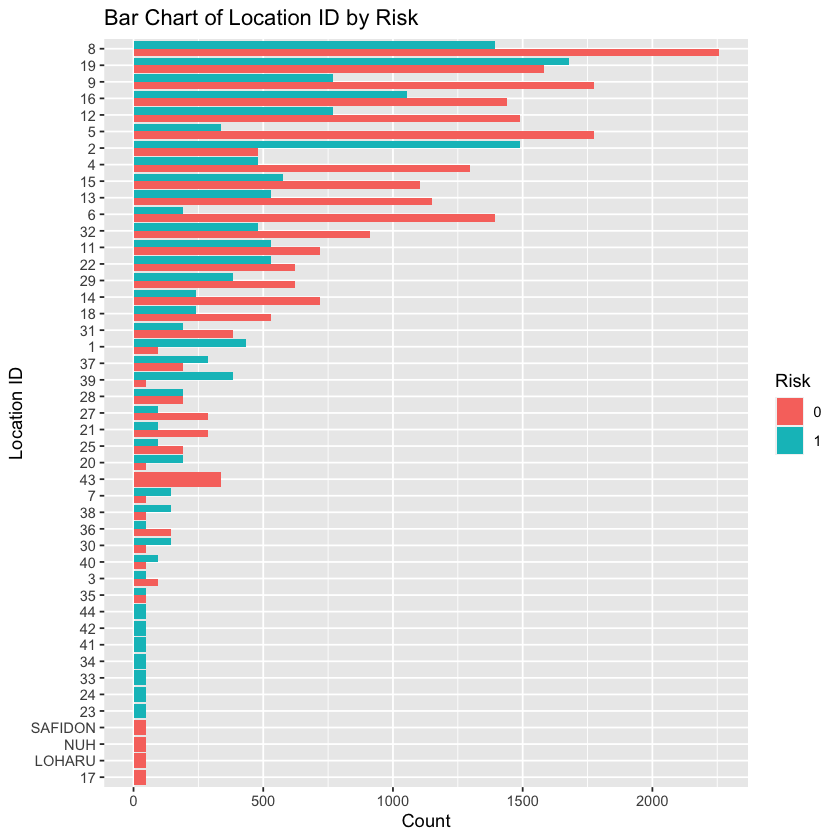

In [6]:
feature_plot1 <- audit_tidy |> ggplot(aes(x = TOTAL, y = Inherent_Risk, color = Risk)) + geom_point() + scale_x_log10() + scale_y_log10() +
    ggtitle('Scatter Plot of TOTAL vs Inherent Risk') +
    xlab('TOTAL') +
    ylab('Inherent Risk')

feature_plot1

feature_plot2 <- ggplot(audit_tidy, aes(x = TOTAL, y = Money_Value)) +
  geom_point(aes(color = Risk), alpha = 0.5) +
  scale_x_log10() + scale_y_log10() +
  ggtitle('Scatter Plot of TOTAL vs Money_Value') +
  xlab('TOTAL') +
  ylab('Money_Value')

feature_plot2

feature_plot3 <- audit_tidy |>
  group_by(LOCATION_ID, Risk) |>
  summarise(count = n(), .groups = "drop") |>
  group_by(LOCATION_ID) |>
  mutate(total = sum(count), risk_ordered = total * as.numeric(Risk)) |>
  ungroup() |>
  mutate(LOCATION_ID = reorder(LOCATION_ID, risk_ordered)) |>
  ggplot(aes(y = LOCATION_ID, x = count, fill = Risk)) +
    geom_bar(stat = "identity", position = "dodge") +
    ggtitle("Bar Chart of Location ID by Risk") +
    ylab("Location ID") +
    xlab("Count") 

feature_plot3



### 3. Methods

We will use the K-nearest neighbour algorithm to build the classifier for our data. We want to find the number of neighbours that will give us the most accurate classification results. By first splitting the data into a training set and a test set, we can then split the training data into a sub training set and a validation set in order to perform a cross validation. Following this we will create a recipe that selects Risk as our class and ___, ____, ____, and ___ as our predictors and standardize the training data. When creating our model using the KNN algorithm, we will set neighbours = tune() so that our cross validation can calculate an accuracy for multiple values of K. We will combine this model with the recipe into a workflow to train the classifier. We will visualize the results (which number of neighbours is appropraite) by plotting the accuracy estimates against the number of neighbors. When building our K nearest neighbours classifier for the dataset, we will use the number of neighbours will give us the most accurate predictions. 

### 4. Expected Outcomes and Significance 